In [ ]:
import gdown
import zipfile

# Cohort level preprocessed data
url_cohort = 'https://drive.google.com/uc?id=1u1bYdXnffUfAM4UeAJIRoH_6Q7C6n0xQ'

output_cohort = '/content/cohort.zip'
gdown.download(url_cohort, output_cohort, quiet=False)

with zipfile.ZipFile('/content/cohort.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')


In [ ]:
# downloading the file containing the model definitions
url_model = 'https://drive.google.com/file/d/1ByZhfo-tKMDJDuKvq6qMmO0o-718PqSw/view?usp=share_link'
gdown.download(url_model, 'model.py', quiet = False, fuzzy = True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tensorflow import keras
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
import os

data_dir = '/content/data/content/data/aug/'

from model import *

# Single Model

In [ ]:
# Setting the correct input dimensions for the model: an image of 224x224 pixels in grayscale as well as a batch_size of 16 for training
size = 224
input_dim = (size, size, 1)
batch_size = 16

In [ ]:
# Defining the generator to calculate the class weights
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()

datagen = image_generator.flow_from_directory(
        data_dir,
        target_size=(size, size),
        batch_size=1,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=True)

In [ ]:
# balance the classes to achieve more better training results
class_names = list(datagen.class_indices.keys()) # getting the class names

class_weights = class_weight.compute_class_weight(
                'balanced',
                classes = np.unique(datagen.classes),
                y = datagen.classes)

class_weights = dict(enumerate(class_weights))

In [ ]:
# Defining the data generators that will load the dataset from disk during training.
# Here we use two generators with the same basic settings, one to load the training
# and one to load the validation dataset with a split of 80/20.
# The ImageDataGenerator furthermore assigns the classes based on the folder name
# an image is stored in.

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(size, size),
    shuffle=True,
    seed=42,
    validation_split=0.2, 
    subset ='training')

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(size, size),
    shuffle=True,
    seed = 42,
    validation_split=0.2, 
    subset = 'validation')

In [ ]:
# Defining the model from the model definition file with 30 classes and an
# L2-regularization factor of 0.0001

model = single_net(input_dim, 30, 0.0001)
model.summary()

In [ ]:
# Setting up the step decay for the learning rate. based on the epoch, this will
# half the initial rate every 16 epochs. To prevent too slow training, the 
# lowest the learning rate can be is set to 0.00001.

def step_decay(epoch, lr):
    if lr <= 0.00001:
        return 0.00001
    else:
        initial_lrate = 0.001
        drop = 0.5
        epochs_drop = 16.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

# Defining Adam as the optimizer with the standard settings used in tensorflow.
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Defining the callbacks used during training.
# ModelCheckpoint creates a savepoint of the network weights everytime the validation loss improves
# EarlyStopping stopps the training if the validation loss has NOT improved for 32 epochs
# LearningRateScheduler is used for the step decay of the learning rate.

callbacks = [ModelCheckpoint('single_model.hdf5', verbose=1, save_best_only=True, save_weights_only=True,
                             monitor = 'val_loss'),
             EarlyStopping(monitor = 'val_loss', patience = 32, restore_best_weights = True),
             LearningRateScheduler(step_decay, verbose=1)]

In [ ]:
# Defining the metrics used during training. 
# Accuracy
# TopKCategoricalAccuracy returns the accuracy of the model in the top 5 predicted categories
# Precision
# Recall

metrics=['accuracy',
         tf.keras.metrics.TopKCategoricalAccuracy(),
         tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall()]

In [ ]:
# Defining the loss used during training. As we are training a multi-class network, 
# the categorical crossentropy loss is used. 

loss = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
# Compiling the model with the parameters set above

model.compile(optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [ ]:
# Starting the training of the network for a maximum of 256 epochs.

epochs = 256
history = model.fit(train_ds,
            validation_data=val_ds,
            batch_size=batch_size, 
            epochs=epochs, 
            shuffle=True, # shuffling the order of the training data each epoch
            class_weight=class_weights,
            callbacks=callbacks, 
            use_multiprocessing = True) # use multiple cpu cores to load the data faster

In [ ]:
# creating a plot of the training and validation loss after the training has finished

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# take a random omage from the validation set and predict its labels using the model, also print the actual labels

i = random.randint(0, len(X_val))
plt.imshow(X_val[i], cmap='gray')

# load the best weights
model.load_weights('single_model.hdf5')

print('Actual_class: ', y_val[i])
pred = model.predict(X_val[i].reshape(1, size, size, 1))

print('Predicted class: ', pred)

In [ ]:
# evaluate the model on the validation set and print metics accuray, precision, recall and AUC
model.evaluate(val_ds)

In [ ]:
# export the final model with the final weights to disk

model.save('/content/single_net.h5')

In [ ]:
# save the feature extractor
fe = get_feature_extractor('single_model.hdf5')
fe.save('/content/feature_extractor.h5')

## Grad Cam

In [ ]:
# linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from numpy import expand_dims
import numpy as np
import cv2

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the model
model = tf.keras.models.load_model('/content/single_net.h5') # Change the path to where the model is saved

In [ ]:
# Get the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Get preprocessed immage and prepare it for further use
image_path = '/content/data/content/data/aug/20-0/000092_0.png' #set the path to a preprocessed image
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
image_gray = cv2.resize(image_gray, (224, 224))
image_gray = image_gray.astype('float32') / 255.0
image_gray = np.expand_dims(image_gray, axis=-1)
image_array = np.expand_dims(image_gray, axis=0)  # Add batch dimension

In [ ]:
# Input the name of the last conv layer
last_conv_layer_name = "conv2d_7"

1/1 [==============================] - 0s 395ms/step


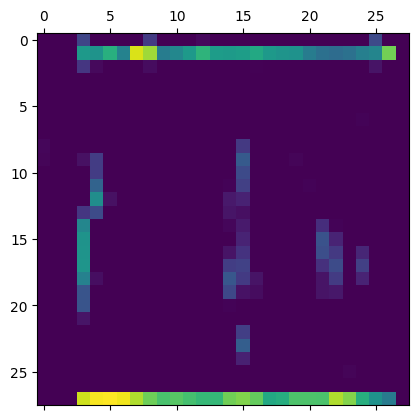

In [ ]:
# Create prediction
preds = model.predict(image_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(image_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

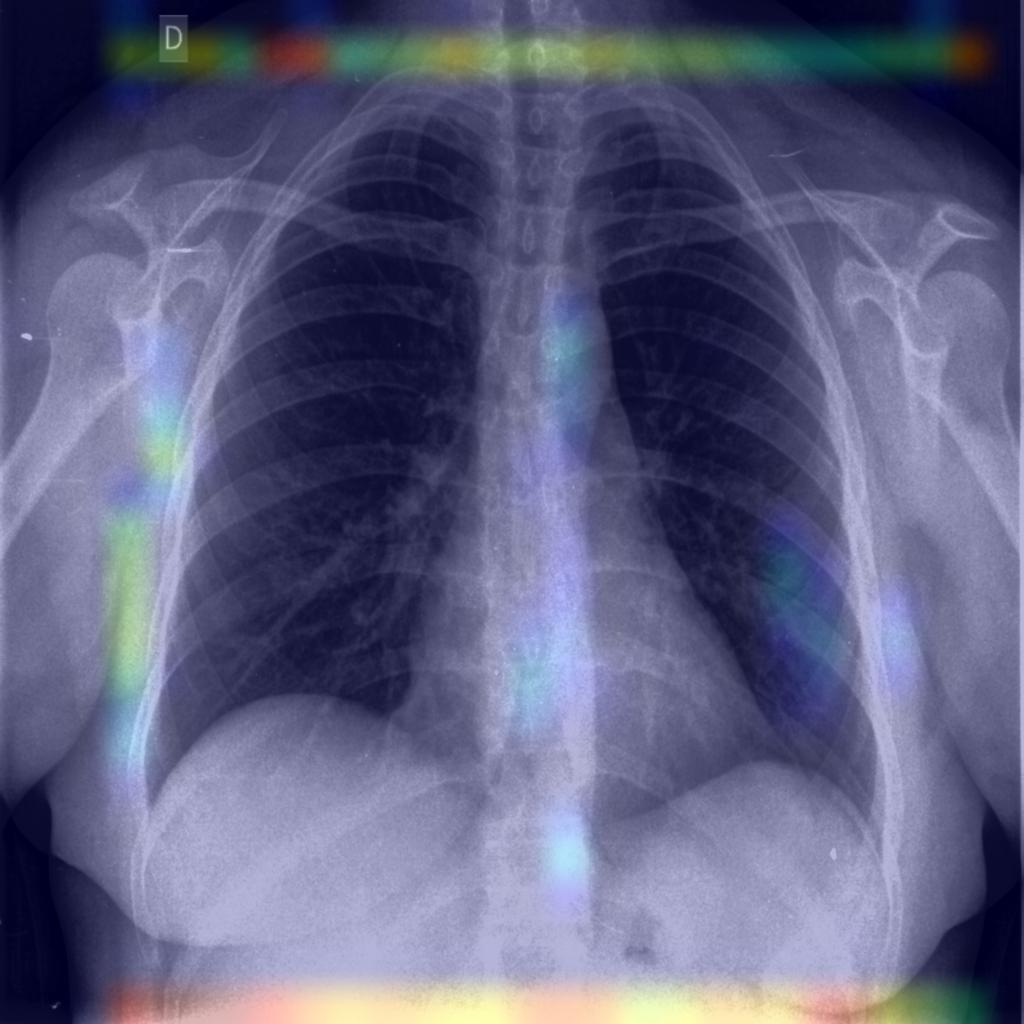

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(image_path, heatmap)

# Dual Model

In [ ]:
# Defining the ImageDataGenerator to load the dataset from disk. Because the
# labels will be split, the data is loaded without a class mode and not shuffled.

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()

datagen = image_generator.flow_from_directory(
        data_dir,
        target_size=(size, size),
        batch_size=1,
        color_mode='grayscale',
        class_mode=None,
        shuffle=False)

In [ ]:
# get all the images from the generator and save them to a numpy array
train_images = []
for i in tqdm(range(len(datagen))):
    image = datagen[i]
    image = image.flatten()
    image = image.reshape((size, size, 1))
    train_images.append(image)

# for each image in the generator, split the class label into two separate labels
# for gender and age using the '-' in the folder name.

age_labels = []
gender_labels = []
for i in range(len(datagen.filenames)):
    datagen.filenames[i] = datagen.filenames[i].split('-')
    datagen.filenames[i][0] = int(datagen.filenames[i][0])
    datagen.filenames[i][1] = int(datagen.filenames[i][1].split('/')[0])
    age_labels.append(datagen.filenames[i][0])
    gender_labels.append(datagen.filenames[i][1])

In [ ]:
# convert the labels to numpy arrays

age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)
train_images = np.array(train_images)

# binarize the labels
gender_lb = LabelBinarizer()
gender_labels = gender_lb.fit_transform(gender_labels)

age_lb = LabelBinarizer()
age_labels = age_lb.fit_transform(age_labels)

# creating the train/test split with a 80/20 split

X_train, X_val, y_train_age, y_val_age, y_train_gender, y_val_gender = train_test_split(
    train_images, age_labels, gender_labels, test_size=0.2, random_state=42)

In [ ]:
# Show a random train image and its labels
import matplotlib.pyplot as plt
import random
i = random.randint(0, len(X_train))
plt.imshow(X_train[i], cmap='gray')
plt.show()
print(f"Age: {y_train_age[i]}")
print(f"Gender: {y_train_gender[i]}")

In [ ]:
# create the dual-output model from the model definition file.
# As this model has two outputs, the number of classes for each 
# must be passed at creation.

classes = [15,1]
model = dual_net(input_dim, classes[0], classes[1], 0.0001)
model.summary()

In [ ]:
# Setting up the step decay for the learning rate. based on the epoch, this will
# half the initial rate every 16 epochs. To prevent too slow training, the 
# lowest the learning rate can be is set to 0.00001.

def step_decay(epoch, lr):
    if lr <= 0.00001:
        return 0.00001
    else:
        initial_lrate = 0.001
        drop = 0.5
        epochs_drop = 16.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

# Defining Adam as the optimizer with the standard settings used in tensorflow.
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Defining the callbacks used during training.
# ModelCheckpoint creates a savepoint of the network weights everytime the validation loss improves
# EarlyStopping stopps the training if the validation loss has NOT improved for 32 epochs
# LearningRateScheduler is used for the step decay of the learning rate.

callbacks = [ModelCheckpoint('dual_model.hdf5', verbose=1, save_best_only=True, save_weights_only=True,
                             monitor = 'val_loss'),
             EarlyStopping(monitor = 'val_loss', patience = 32, restore_best_weights = True),
             LearningRateScheduler(step_decay, verbose=1)]

In [ ]:
# Since we are creating two predictions, one for age and one for gender, the 
# respective outputs must have an individual loss function assinged. For the
# age, we are still prediction a muliticlass prediction, so categorical ce is 
# used. Since the gender is just a single, binary class, the binary ce is used 

losses = {
    "age": "categorical_crossentropy",
    "gender": "binary_crossentropy"
}

# During training, the losses are assigned a weight to control their influence 
# on the combined loss per epoch. As the age is a more important problem here, 
# the influence is higher.

loss_weights = {"age": 0.75, "gender": 0.25}

# Defining the metrics used during training. 
# Accuracy
# TopKCategoricalAccuracy returns the accuracy of the model in the top 5 predicted categories
# Precision
# Recall

metrics=['accuracy',
         tf.keras.metrics.TopKCategoricalAccuracy(),
         tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall()]

# compiling the model with the parameters set above
        
model.compile(optimizer=optimizer,
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics)

In [ ]:
# Starting the training for a maximum of 256 epochs. As there are now two classes, 
# they are passed to the model as a dict.
epochs = 256

history = model.fit(
    x = X_train, 
    y = {'age': y_train_age, 'gender': y_train_gender},
    validation_data=void(0)
        (X_val, {'age': y_val_age, 'gender': y_val_gender}),
    epochs=epochs, 
    batch_size=batch_size,
    shuffle=True,
    callbacks=callbacks)

In [ ]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# take a random omage from the validation set and predict its labels using the model, also print the actual labels
i = random.randint(0, len(X_val))
plt.imshow(X_val[i], cmap='gray')

# load the best weights
model.load_weights('dual_model.hdf5')

print('Actual age: ', y_val_age[i])
print('Actual gender:', y_val_gender[i])

pred = model.predict(X_val[i].reshape(1, size, size, 1))

print('Predicted age: ', pred[0])
print('Predicted gender: ', pred[1])

In [ ]:
# evaluate the model on the validation set and print metics accuray, precision, recall and AUC

model.evaluate(X_val, {'age': y_val_age, 'gender': y_val_gender})